In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
import nbformat
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def preprocess(data):
    # 범주형 변수 원핫 인코딩
    data = pd.get_dummies(data, columns=['Type of Drink', 'EGFR mutation Detection', 'Smoke'])

    # bmi 계산
    data['bmi'] = data['Weight'] / (data['Height']/100)**2
    data.drop(['Weight', 'Height'], axis=1, inplace=True)

    return data

train_data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
train_data.drop('~', axis=1, inplace=True)
X_test.drop('No', axis=1, inplace=True)

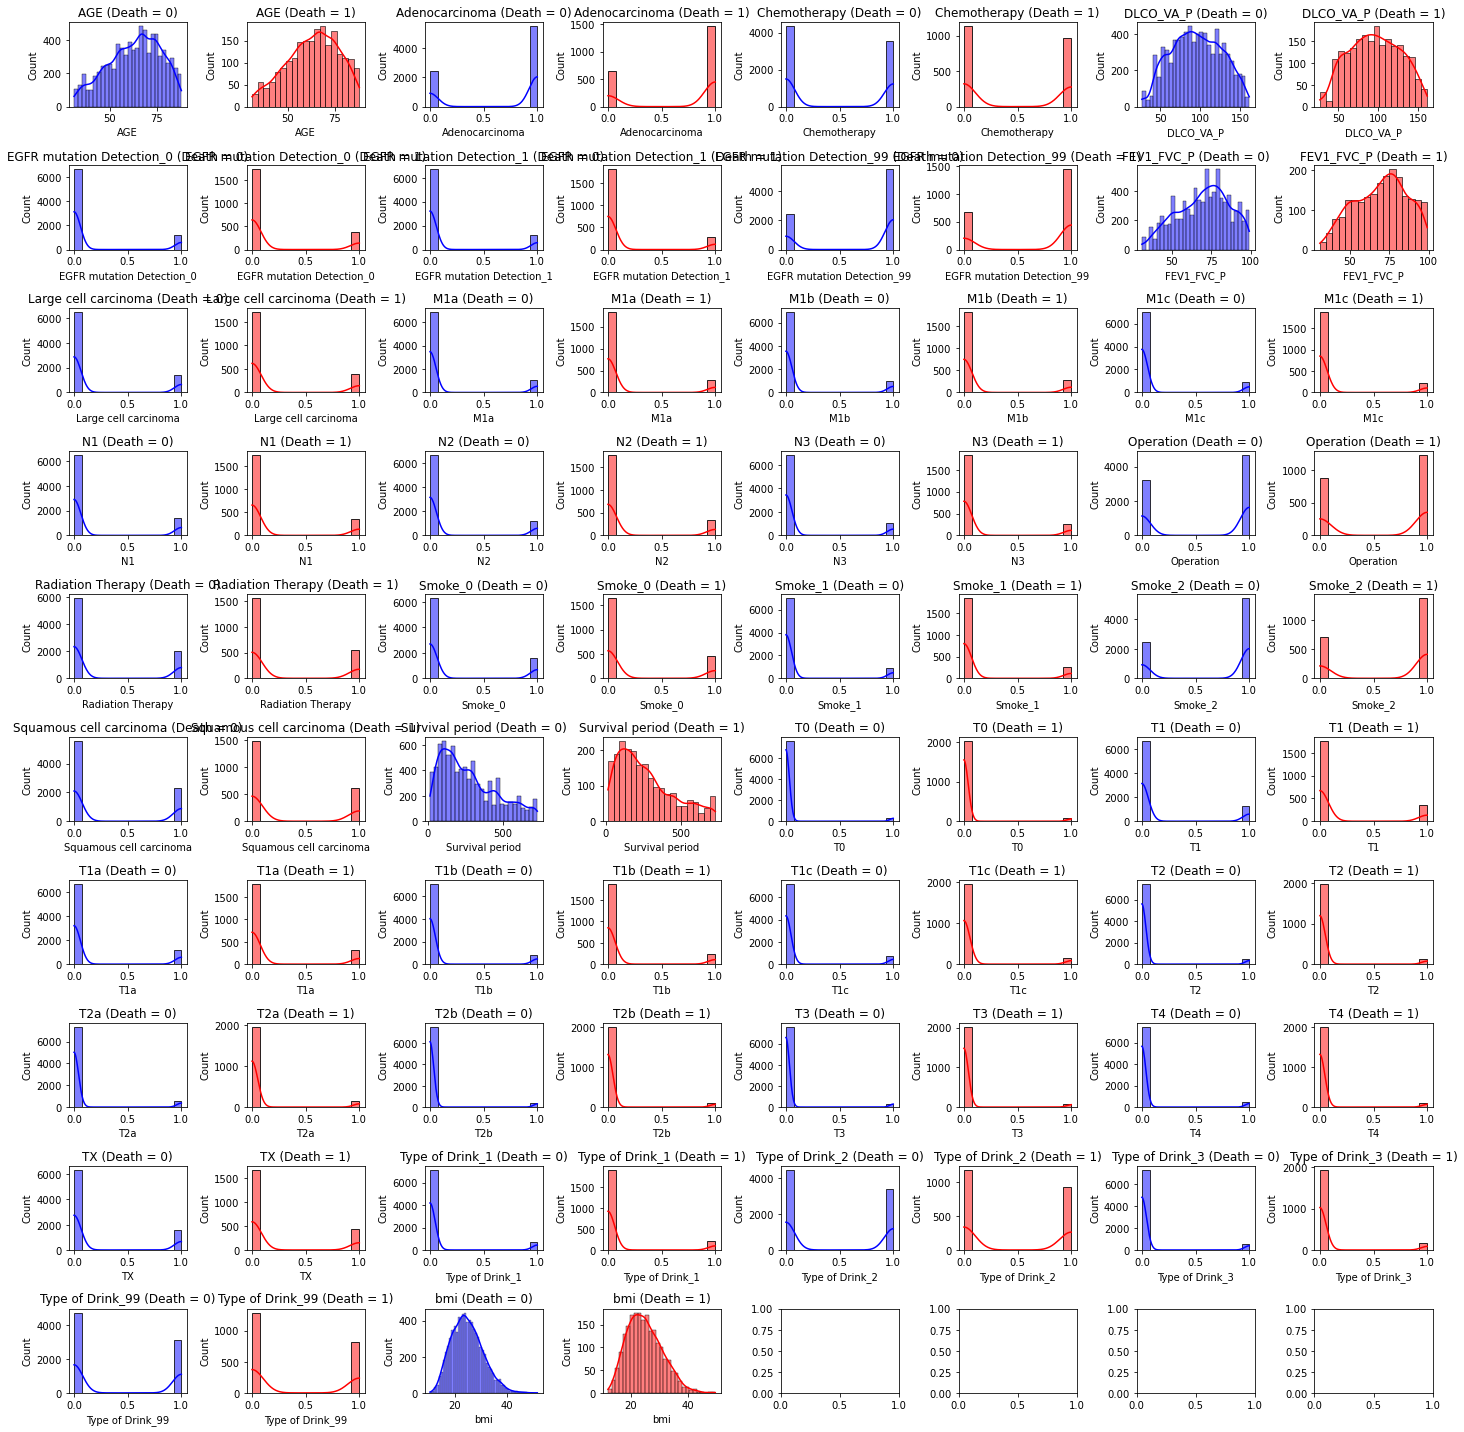

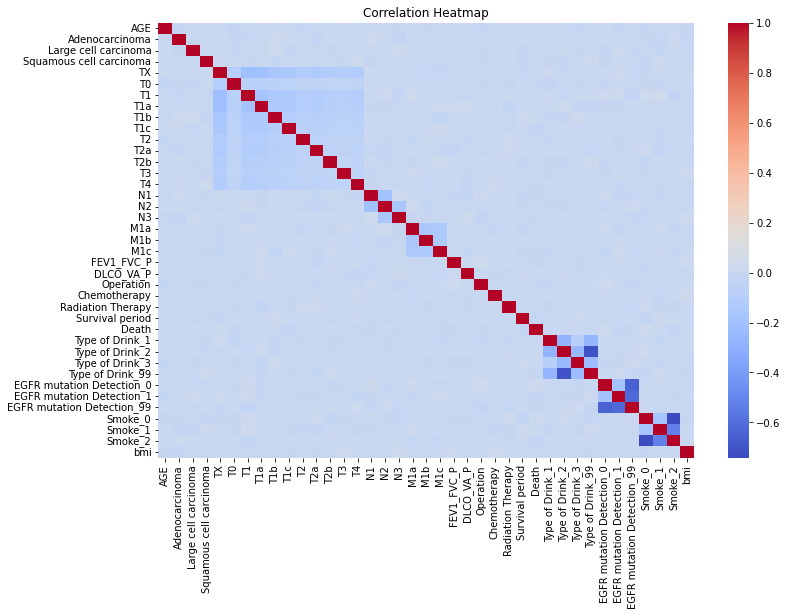

In [23]:
# 'Death' 열을 기준으로 데이터 분할
data_death_0 = train_data[train_data['Death'] == 0]
data_death_1 = train_data[train_data['Death'] == 1]

# 'Death' 열을 제외한 나머지 열 이름
columns = train_data.columns.difference(['Death'])

# Subplot 그리기
n_cols = 8
n_rows = (len(columns) * 2) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))

for i, col in enumerate(columns):
    row = (i * 2) // n_cols
    col_index_0 = (i * 2) % n_cols
    col_index_1 = col_index_0 + 1
    
    # 'Death'가 0인 경우의 히스토그램
    sns.histplot(data_death_0[col], kde=True, ax=axes[row, col_index_0], color='blue')
    axes[row, col_index_0].set_title(f'{col} (Death = 0)')
    
    # 'Death'가 1인 경우의 히스토그램
    sns.histplot(data_death_1[col], kde=True, ax=axes[row, col_index_1], color='red')
    axes[row, col_index_1].set_title(f'{col} (Death = 1)')

plt.tight_layout()
plt.show()

# Heatmap 그리기
plt.figure(figsize=(12, 8))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



In [9]:
train_data = preprocess(train_data)
X_test = preprocess(X_test)

X, y = train_data[[col for col in train_data.columns if col != 'Death']], train_data['Death']

# StratifiedKFold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

# 분류 모델 리스트
models = {
    # 'RandomForest': RandomForestClassifier,
    # 'GradientBoosting': GradientBoostingClassifier,
    # 'SVC': SVC,
    # 'DecisionTree': DecisionTreeClassifier,
    'XGBoost': xgb.XGBClassifier
    # 'ExtraTrees': ExtraTreesClassifier,
    # 'NaiveBayes': GaussianNB,
    # 'CatBoost': CatBoostClassifier
}

# 오버샘플링 기법 리스트
over_samplers = {
    'SMOTE': SMOTE,
    # 'ADASYN': ADASYN,
    # 'BorderlineSMOTE': BorderlineSMOTE
}

# 언더샘플링 기법 리스트
under_samplers = {
    # 'RandomUnderSampler': RandomUnderSampler,
    'TomekLinks': TomekLinks,
    # 'NearMiss': NearMiss,
    # 'EditedNearestNeighbours': EditedNearestNeighbours
}

# 샘플링 기법 결합
combined_samplers = {
    'SMOTETomek': SMOTETomek
}

# Custom F1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

def objective(trial, model_name, sampler_name, sampler, X, y):
    # 하이퍼파라미터 검색 공간 설정
    if model_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 10, 50),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

    # 모델 생성
    model = models[model_name](**params)

    # 데이터 샘플링
    if sampler:
        if sampler_name != 'TomekLinks':
            X_resampled, y_resampled = sampler(random_state=42).fit_resample(X, y)
        else:
            X_resampled, y_resampled = sampler().fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    # 교차 검증 설정
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring=f1_scorer)
    
    return np.mean(cv_results)

# 전체 학습 프로세스
study_results = []

total_trials = 100  # 각 조합당 실행할 trial 수
num_combinations = len(models) * (1 + len(over_samplers) + len(under_samplers) + len(combined_samplers))
total_progress = total_trials * num_combinations

start_time = time.time()

with tqdm(total=total_progress, desc="Optimization Progress") as pbar:
    for model_name in models.keys():
        # 원본 데이터로 학습
        study = optuna.create_study(direction='maximize', sampler=TPESampler())
        study.optimize(lambda trial: objective(trial, model_name, None, None, X, y), n_trials=total_trials, callbacks=[lambda study, trial: pbar.update()])
        study_results.append((model_name, 'Original', study.best_trial.value))

        # 오버샘플링 기법 적용
        for sampler_name, sampler in over_samplers.items():
            study = optuna.create_study(direction='maximize', sampler=TPESampler())
            study.optimize(lambda trial: objective(trial, model_name, sampler_name, sampler, X, y), n_trials=total_trials, callbacks=[lambda study, trial: pbar.update()])
            study_results.append((model_name, sampler_name, study.best_trial.value))

        # 언더샘플링 기법 적용
        for sampler_name, sampler in under_samplers.items():
            study = optuna.create_study(direction='maximize', sampler=TPESampler())
            study.optimize(lambda trial: objective(trial, model_name, sampler_name, sampler, X, y), n_trials=total_trials, callbacks=[lambda study, trial: pbar.update()])
            study_results.append((model_name, sampler_name, study.best_trial.value))

        # 샘플링 기법 결합 적용
        for sampler_name, sampler in combined_samplers.items():
            study = optuna.create_study(direction='maximize', sampler=TPESampler())
            study.optimize(lambda trial: objective(trial, model_name, sampler_name, sampler, X, y), n_trials=total_trials, callbacks=[lambda study, trial: pbar.update()])
            study_results.append((model_name, sampler_name, study.best_trial.value))

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTotal optimization time: {elapsed_time:.2f} seconds")

# 결과 출력 및 저장
results_df = pd.DataFrame(study_results, columns=['Model', 'Sampler', 'Best F1 Score'])
print(results_df)

# CSV 파일로 저장
results_df.to_csv('study_results.csv', index=False)
print("Results saved to 'study_results.csv'")


Optimization Progress:   0%|          | 0/400 [00:00<?, ?it/s][I 2024-05-17 22:25:38,863] A new study created in memory with name: no-name-923fd807-19cc-476c-9b27-6da97d69526b
[W 2024-05-17 22:25:39,471] Trial 0 failed with parameters: {'n_estimators': 438, 'learning_rate': 0.020217932549213447, 'max_depth': 49, 'subsample': 0.5715283910805549, 'colsample_bytree': 0.843740157495987} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\seriz\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\seriz\AppData\Local\Temp/ipykernel_25948/445966.py", line 81, in <lambda>
    study.optimize(lambda trial: objective(trial, model_name, None, None, X, y), n_trials=total_trials, callbacks=[lambda study, trial: pbar.update()])
  File "C:\Users\seriz\AppData\Local\Temp/ipykernel_25948/445966.py", line 64, in objective
    cv_results = cross_val_score(model, X_resampled, y

KeyboardInterrupt: 

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2341, stratify=y)

# 결과 저장 여부
save = True

sampler = SMOTETomek(random_state=86)

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

params = {'n_estimators': 72, 
          'learning_rate': 0.027677690827499442, 
          'max_depth': 23, 
          'subsample': 0.6014655630730819, 
          'colsample_bytree': 0.5113427843608438}

model = xgb.XGBClassifier(**params, n_jobs=-1)
model.fit(X_train_resampled, y_train_resampled)
pred = model.predict(X_val)
print(f1_score(y_val, pred, average='weighted'))
print(classification_report(y_val, pred))


X_train_submission, y_train_submission = train_data[[col for col in train_data.columns if col != 'Death']], train_data['Death']
X_train_submission, y_train_submission = sampler.fit_resample(X_train_submission, y_train_submission)
model.fit(X_train_submission, y_train_submission)
predictions = model.predict(X_test)
results = pd.DataFrame({'Death': predictions}, index=pd.Index(range(len(X_test)), name='ID'))
print(results['Death'].value_counts())


if save:
    # 저장할 폴더 경로
    folder_path = './savefiles'

    # submission 파일 이름 생성
    submission_file = 'submission0.csv'
    i = 0
    while os.path.exists(os.path.join(folder_path, submission_file)):
        i += 1
        submission_file = f'submission{i}.csv'

    # results 데이터프레임을 submission 파일로 저장
    results.to_csv(os.path.join(folder_path, submission_file))

    # 노트북 파일 이름 생성
    notebook_file = f'submission{i}.ipynb'

    # 현재 노트북 파일 가져오기
    notebook_path = 'main.ipynb'  # 현재 노트북 파일의 경로
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)

    # 노트북 파일 저장
    with open(os.path.join(folder_path, notebook_file), 'w', encoding='utf-8') as f:
        nbformat.write(notebook, f)

    print(f'{submission_file}과 {notebook_file}이 저장되었습니다.')

0.7178900981504974
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       790
           1       0.46      0.06      0.11       210

    accuracy                           0.79      1000
   macro avg       0.63      0.52      0.49      1000
weighted avg       0.73      0.79      0.72      1000

0    4973
1      27
Name: Death, dtype: int64


OSError: Cannot save file into a non-existent directory: 'savefiles'